# Longitudinal analysis - 1 Year follow up sample

## Analysis overview

#### Discovery sample

1. Model fitting: [`Model fitting - Discovery.ipynb`](<../../notebooks/discovery/Model fitting - Discovery.ipynb>)
2. Confidence analysis: [`Confidence analysis - Discovery.ipynb`](<../../notebooks/discovery/Confidence analysis - Discovery.ipynb>)
3. Transdiagnostic factor estimation: [`Transdiagnostic factors - Discovery.ipynb`](<../../notebooks/discovery/Transdiagnostic factors - Discovery.ipynb>)
4. Symptom-behaviour analyses: [`Symptom analyses - Discovery.ipynb`](<../../notebooks/discovery/Symptom analyses - Discovery.ipynb>)

#### Replication sample

1. Model fitting: [`Model fitting - Replication.ipynb`](<../../notebooks/replication/Model fitting - Replication.ipynb>)
2. Confidence analysis: [`Confidence analysis - Replication.ipynb`](<../../notebooks/replication/Confidence analysis - Replication.ipynb>)
3. Two-step task analysis: [`Two-step modelling - Replication.ipynb`](<../../notebooks/replication/Two-step modelling - Replication.ipynb>)
4. Transdiagnostic factor estimation: [`Transdiagnostic factors - Replication.ipynb`](<../../notebooks/replication/Transdiagnostic factors - Replication.ipynb>)
5. Symptom-behaviour analyses: [`Symptom analyses - Replication.ipynb`](<../../notebooks/replication/Symptom analyses - Replication.ipynb>)

#### Test-retest sample

1. Model-fitting: [`Model fitting - Retest.ipynb`](<../../notebooks/retest/Model fitting - Retest.ipynb>)
2. Two-step modelling: [`Two-step modelling - Retest.ipynb`](<../../notebooks/retest/Two-step modelling - Retest.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Retest.ipynb`](<../../notebooks/retest/Test-retest - Retest.ipynb>)

#### Follow-up sample

1. Model fitting: [`Model fitting - Follow up.ipynb`](<../../notebooks/follow-up/Model fitting - Follow up.ipynb>)
2. Transdiagnostic factor estimation: [`Transdiagnostic factors - Follow up.ipynb`](<../../notebooks/follow-up/Transdiagnostic factors - Follow up.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Follow up.ipynb`](<../../notebooks/follow-up/Test-retest - Follow up.ipynb>)
4. Longitudinal analyses: [`Longitudinal analyses - Follow up.ipynb`](<../../notebooks/follow-up/Longitudinal analyses - Follow up.ipynb>)

#### Follow-up sample (1 year)

1. Model fitting: [`Model fitting - Follow up 1yr.ipynb`](<../../notebooks/follow-up/Model fitting - Follow up 1yr.ipynb>)
2. Transdiagnostic factor estimation: [`Transdiagnostic factors - Follow up 1yr.ipynb`](<../../notebooks/follow-up/Transdiagnostic factors - Follow up 1yr.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Follow up 1yr.ipynb`](<../../notebooks/follow-up/Test-retest - Follow up 1yr.ipynb>)
4. Longitudinal analyses: [`Longitudinal analyses -  Follow up 1yr.ipynb`](<../../notebooks/follow-up/Longitudinal analyses - Follow up 1yr.ipynb>)

## Notebook overview

In this notebook we explore relationships between change in behaviour and change in symptoms over a ~3 month period in a subset of participants.

## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from stats_utils.regression.utils import (
    ols_to_markdown_table,
    run_regression_and_plot,
)

from transition_uncertainty.analysis_utils import (
    calculate_intraclass_correlations,
    compile_ols_results,
)
from transition_uncertainty.data import load_and_process_data
from transition_uncertainty.plotting import (
    plot_timepoint_correlations,
    plot_timepoint_stripplots,
)
from transition_uncertainty.style import set_style
from transition_uncertainty.utils import (
    caption_and_save_markdown_tables,
    check_directories,
)

# Raise an error if we're not in the root directory by checking if the data folder exists
check_directories()

set_style("style.mplstyle")

# Create necessary diretory if it does not exist
if not os.path.exists("results/follow-up-1yr/longitudinal_symptom_models"):
    os.makedirs("results/follow-up-1yr/longitudinal_symptom_models")

# Dictionary for renaming variables
variable_rename_dict = {
    "Compul__change": r"$\Delta$" + "CIT",
    "AD__change": r"$\Delta$" + "AD",
    "SW__change": r"$\Delta$" + "SW",
    "GAD_7__change": r"$\Delta$" + "GAD 7",
    "PHQ_8__change": r"$\Delta$" + "PHQ 8",
    "MB_MF_WAIC_diff__T1": "Model-based - model-free T1",
    "transition_var__T1": "Transition uncertainty T1",
    "gender": "Gender",
    "age": "Age",
    "motivation__change": r"$\Delta$" + "Motivation",
    "bet_correct__change": r"$\Delta$" + "Accuracy",
}

Font Heebo already available in Matplotlib.
Matplotlib style set to: style.mplstyle with font Heebo


/users/user/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load data

Here we load in the data from T1 and T2 and combine it into a single dataframe with columns labelled appropriately.

In [2]:
qdata_T1 = load_and_process_data(
    "discovery",
    scale=False,
    include_confidence=False,
    include_performance=False,
)
qdata_T2 = load_and_process_data(
    "follow-up-1yr",
    scale=False,
    include_confidence=False,
    include_performance=False,
)

# merge on subjectID
qdata = pd.merge(
    qdata_T1,
    qdata_T2.drop(columns=["age", "gender"]),
    on="subjectID",
    suffixes=("__T1", "__T2"),
)

# Remove subjects who have missing values for GAD_7 or PHQ_8 - should only be
# one subject
qdata = qdata.loc[
    qdata[["GAD_7__T1", "GAD_7__T2", "PHQ_8__T1", "PHQ_8__T2"]]
    .notnull()
    .all(axis=1)
]

# Calculate change scores
columns = [
    "GAD_7",
    "PHQ_8",
    "AD",
    "Compul",
    "SW",
    "tau_prob",
    "MB_MF_WAIC_diff",
    "transition_var",
    "motivation",
]
for col in columns:
    qdata[f"{col}__change"] = qdata[f"{col}__T2"] - qdata[f"{col}__T1"]

# Scaling Variables: Normalize all variables, excluding 'subjectID' and
# 'gender'. List comprehension generates list of columns to be scaled.
cols_to_scale = [
    col for col in qdata.columns if col not in ["subjectID", "gender"]
]

# Standardizing specified columns by subtracting mean and dividing by standard
# deviation.
qdata[cols_to_scale] = qdata[cols_to_scale].apply(
    lambda x: (x - x.mean()) / x.std(), axis=0
)

Initial number of subjects: 600
Number of included subjects after excluding gender != 0 or 1: 592
Number of included subjects after excluding age < 18 or >= 100: 592
Number of included subjects after excluding attention check failures: 551
Mean (SD) age = 40.75 (12.32)
n male = 275; n female = 276
Number scoring above cutoff for GAD: 116 (21.05%)
Number scoring above cutoff for MDD: 128 (23.23%)
Number of subjects after filtering and processing: 551
Initial number of subjects: 344
Number of included subjects after excluding gender != 0 or 1: 343
Number of included subjects after excluding age < 18 or >= 100: 343
Number of included subjects after excluding attention check failures: 326
Mean (SD) age = 43.78 (12.22)
n male = 172; n female = 154
Number scoring above cutoff for GAD: 40 (12.27%)
Number scoring above cutoff for MDD: 58 (17.79%)
Number of subjects after filtering and processing: 326


## Changes in transdiagnostic factors

First we examine whether changes in task behaviour are predicted by changes in any of the three transdiagnostic dimensions. We do this by constructing a regression model for each parameter, predicting change in that parameter from change in each of the three transdiagnostic dimensions while controlling for age, gender, and change in motivation. 

The model takes the form:

$ \Delta \theta \sim \text{age} + \text{gender} + \Delta \text{motivation} + \theta_{T1} + \Delta \text{AD} + \Delta \text{Compul} + \Delta \text{SW} $


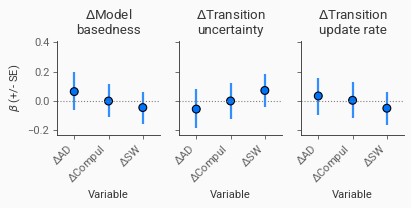

In [3]:
# Parameters for the models and plots
variables = [
    "MB_MF_WAIC_diff",
    "transition_var",
    "tau_prob",
]
titles = [
    r"$\Delta$" + "Model\nbasedness",
    r"$\Delta$" + "Transition\nuncertainty",
    r"$\Delta$" + "Transition\nupdate rate",
]

# Create subplots
f, ax = plt.subplots(1, 3, figsize=(5.25, 2.7), sharey=True)

# Create an empty list to store model objects
transdiagnostic_models = []

# Create an empty list to store markdown tables
transdiagnostic_markdown_tables = {}

# Loop through the variables and corresponding titles, running regression and
# plotting for each
for i, (var, title) in enumerate(zip(variables, titles)):
    # Update regression formula with T! scores for this variable
    model_formula = f"age + gender + motivation__change + {var}__T1 + \
        AD__change + Compul__change + SW__change"

    model, _ = run_regression_and_plot(
        qdata,
        f"{var}__change",
        model_formula,
        20000,
        save_fig=False,
        show_summary=False,
        ax=ax[i],
        forest_plot_kwargs={
            "exclude_param_names": [
                "age",
                "gender",
                "motivation__change",
                f"{var}__T1",
            ],
            "significance_thresholds": {
                0.001 / 3: "***",
                0.01 / 3: "**",
                0.05 / 3: "*",
            },
            "alpha": 0.05 / 3,
        },
    )
    transdiagnostic_models.append(model)  # Store the model object

    # Store the table in markdown form
    transdiagnostic_markdown_tables[title] = ols_to_markdown_table(
        model,
        alpha_corr=0.05 / 3,
        predictor_rename_dict=variable_rename_dict,
    )

    # Set title for each subplot
    ax[i].set_title(title)

    # Update xtick labels - replace variable with r"$\Delta$ variable"
    current_labels = [label.get_text() for label in ax[i].get_xticklabels()]

    # Update labels to include delta symbol
    new_labels = [
        r"$\Delta$" + label.split("__")[0] for label in current_labels
    ]

    # Set the new labels
    ax[i].set_xticklabels(new_labels)


# Remove y label from plots 1-4
for i in range(1, 3):
    ax[i].set_ylabel("")

# Tighten layout
plt.tight_layout()

# Combine results into a dataframe
transdiagnostic_results = compile_ols_results(transdiagnostic_models)

# Save the results to a csv file
transdiagnostic_results.to_csv(
    "results/follow-up-1yr/longitudinal_symptom_models/transdiagnostic_results.csv", index=False
)

## Changes in state anxiety and depression

We then use the approach to investigate links between changes in behaviour and changes in PHQ-8 and GAD-7 scores. The model takes the form:

$ \Delta \theta \sim \text{age} + \text{gender} + \Delta \text{motivation} + \theta_{T1} + \Delta \text{GAD7} + \Delta \text{PHQ8}$

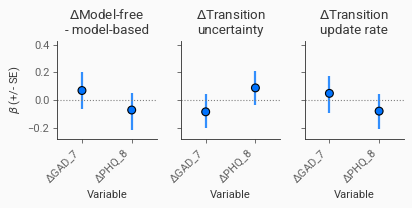

In [4]:
# Parameters for the models and plots
variables = [
    "MB_MF_WAIC_diff",
    "transition_var",
    "tau_prob",
]
titles = [
    r"$\Delta$" + "Model-free\n- model-based",
    r"$\Delta$" + "Transition\nuncertainty",
    r"$\Delta$" + "Transition\nupdate rate",
]

# Create subplots
f, ax = plt.subplots(1, 3, figsize=(5.25, 2.7), sharey=True)

# Create an empty list to store model objects
anx_dep_models = []

# Create an empty list to store markdown tables
anx_dep_markdown_tables = {}

# Loop through the variables and corresponding titles, running regression and
# plotting for each
for i, (var, title) in enumerate(zip(variables, titles)):
    # Update regression formula with T! scores for this variable
    model_formula = f"age + gender + motivation__change + {var}__T1 + \
        GAD_7__change + PHQ_8__change"

    model, _ = run_regression_and_plot(
        qdata,
        f"{var}__change",
        model_formula,
        20000,
        save_fig=False,
        show_summary=False,
        ax=ax[i],
        forest_plot_kwargs={
            "exclude_param_names": [
                "age",
                "gender",
                "motivation__change",
                f"{var}__T1",
            ],
            "significance_thresholds": {
                0.001 / 3: "***",
                0.01 / 3: "**",
                0.05 / 3: "*",
            },
            "alpha": 0.05 / 3,
        },
    )
    anx_dep_models.append(model)  # Store the model object

    # Store the table in markdown form
    anx_dep_markdown_tables[title] = ols_to_markdown_table(
        model, alpha_corr=0.05 / 3, predictor_rename_dict=variable_rename_dict
    )

    # Set title for each subplot
    ax[i].set_title(title)

    # Update xtick labels - replace variable with r"$\Delta$ variable"
    current_labels = [label.get_text() for label in ax[i].get_xticklabels()]

    # Update labels to include delta symbol
    new_labels = [
        r"$\Delta$" + label.split("__")[0] for label in current_labels
    ]

    # Set the new labels
    ax[i].set_xticklabels(new_labels)


# Remove y label from plots 1-4
for i in range(1, 3):
    ax[i].set_ylabel("")

# Tighten layout
plt.tight_layout()

# Combine results into a dataframe
anx_dep_results = compile_ols_results(anx_dep_models)

# Save the results to a csv file
anx_dep_results.to_csv(
    "results/follow-up-1yr/longitudinal_symptom_models/anx_dep_results.csv", index=False
)

## Save markdown tables

We save the tables as markdown files for easy inclusion in the manuscript.

In [5]:
all_tables = {
    "transdiagnostic_longitudinal": transdiagnostic_markdown_tables,
    "anx_dep_longitudinal": anx_dep_markdown_tables,
}

caption_and_save_markdown_tables(
    all_tables, "follow up", "paper/supplementary_tables.md", append=True
)

Appending to existing file: paper/supplementary_tables.md
Conversion to PDF completed successfully.
Conversion to docx completed successfully.
